# [hotsline](https://github.com/AntoineGrimaldi/hotsline) algorithm to replicate results from [this paper](https://www.techrxiv.org/articles/preprint/A_robust_event-driven_approach_to_always-on_object_recognition/18003077/1)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd ../hots
import tonic, torch, os, pickle, glob
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import apply_jitter, get_loader, get_sliced_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy, make_and_display_ts
import matplotlib.pyplot as plt
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
#record_path = '/envau/work/neopto/USERS/GRIMALDI/HOTS/hotsline/Records/'
record_path = '../Records/'

device = 'cuda'

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.19
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


In [4]:
kfold_test = None
kfold_clust = 10
ts_batch_size = int(3e4)

dataset_name = 'gesture'
slicing_time_window = 1e6

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True, transform=type_transform)
testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False, transform=type_transform)
loader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_clust)
trainloader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_test)
num_sample_train = len(trainloader)
testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=True, kfold=kfold_test)
num_sample_test = len(testloader)
n_classes = len(testset.classes)
print(f'number of samples in the training set: {len(trainloader)}')
print(f'number of samples in the testing set: {len(testloader)}')

../../Data/DVSGesture/metadata/gesture_1000_True_True
Read metadata from disk.
../../Data/DVSGesture/metadata/gesture_1000_True_True
Read metadata from disk.
../../Data/DVSGesture/metadata/gesture_1000_True_False
Read metadata from disk.
number of samples in the training set: 1077
number of samples in the testing set: 264


In [4]:
name = 'homeohots'
homeo = True
timestr = '2023-04-03'
dataset_name = 'gesture'

Rz = [4, 8]
N_neuronz = [64, 128]
layer_threshold = [0.05, 0.1]
layer_threshold = None
tauz = [5e3*2, 5e3*N_neuronz[0]]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, record_path=record_path)

initial_name = hots.name

filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists(record_path):
    os.mkdir(record_path)
    os.mkdir(record_path+'networks/')
path = record_path+'networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold, ts_batch_size = ts_batch_size, device = device)
    
#hots.plotlayers();
    
jitter = (None, None)

hots.coding(trainloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, layer_threshold = layer_threshold, training=True, ts_batch_size = ts_batch_size, verbose=False, device = device)
hots.coding(testloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, layer_threshold = layer_threshold, training=False, ts_batch_size = ts_batch_size, verbose=False, device = device)

num_workers = 0
learning_rate = 0.00005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 5e3*64
drop_proba = .95

ts_batch_size = 300

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
print(model_path)

drop_transform = tonic.transforms.DropEvent(p = drop_proba)
kfold_mlr = None

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([type_transform]))
trainoutputloader = get_loader(trainset_output, kfold = kfold_mlr)
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=testset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

print(f'number of samples in the training set: {len(trainoutputloader)}')
print(f'number of samples in the testing set: {len(testoutputloader)}')

score = make_histogram_classification(trainset_output, testset_output, N_output_neurons)
print(f'Histogram classification performance: {np.round(score,3)*100} %')

../Records/networks/2023-04-03_gesture_homeohots_True_[64, 128]_[10000.0, 320000.0]_[4, 8]_320000.0_5e-05_(0.9, 0.999)_33_0.95_(None, None).pkl
number of samples in the training set: 1077
number of samples in the testing set: 264
Histogram classification performance: 69.69999999999999 %


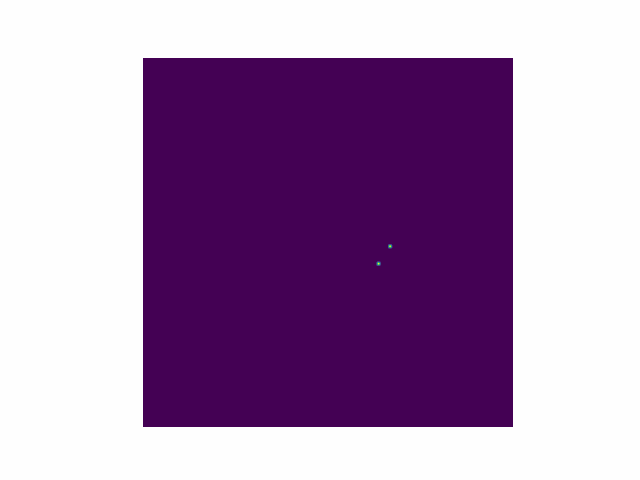

In [6]:
tau = 5e3*2 
events, target = next(iter(trainloader))
file_name = f'DVS128_{target}_{tau}_{events.shape[1]}'
file_name = f'DVS128_tensor([6])_58068'
make_and_display_ts(events.squeeze(0), file_name, trainset, tau, polarity= 'off', nb_frames = 100, ts_batch_size = int(1e4), device = 'cuda')

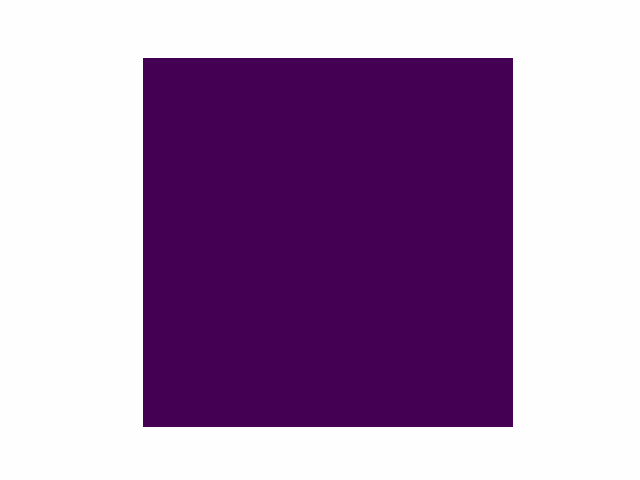

In [24]:
make_and_display_ts(events.squeeze(0), file_name, trainset, tau, polarity= 'on', nb_frames = 100, ts_batch_size = int(1e4), device = 'cuda')

In [6]:
past_trainings = glob.glob(glob.escape(model_path[:-10])+'*')
if len(past_trainings)==1:
    print(past_trainings)
    with open(past_trainings[0], 'rb') as file:
        classif_layer, mean_loss_epoch = pickle.load(file)

['../Records/networks/2023-01-04_gesture_homeohots_True_[32, 64]_[10000.0, 160000.0]_[4, 8]_320000.0_5e-05_(0.9, 0.999)_33_0.95_(None, None)_it14.pkl']


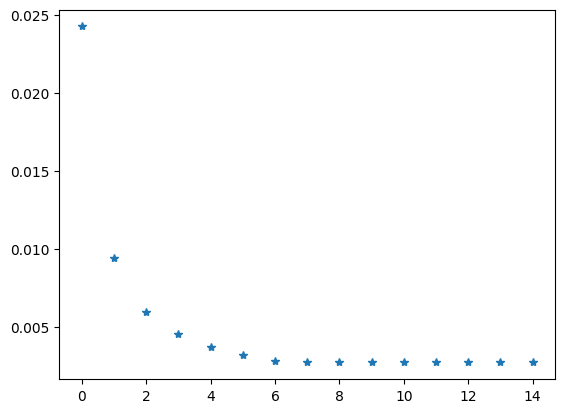

In [7]:
plt.plot(mean_loss_epoch, '*')

In [8]:
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}_it14.pkl'
mlr_threshold = None
onlinac, best_probability, meanac, lastac = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, save_likelihood = False)

Number of chance decisions: 0
90th quantile for number of events: 114936.70000000004
Mean accuracy: 71.7%
Last accuracy: 78.4%
Highest probability accuracy: 78.8%


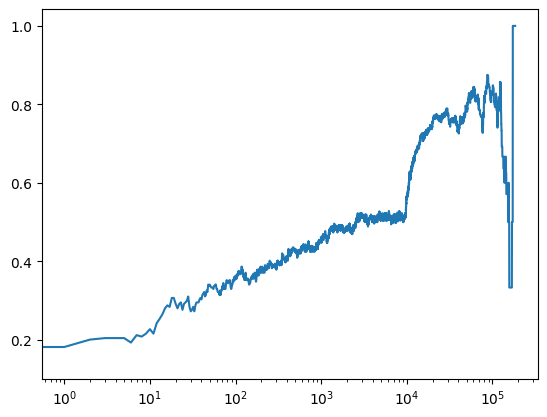

In [9]:
plt.semilogx(onlinac)

In [10]:
num_workers = 0
learning_rate = 0.00005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
sensor_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 5e3*64
drop_proba = .95

ts_size = (31,31)
ts_batch_size = int(1e4)

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_conv_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_conv_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
print(model_path)

drop_transform = tonic.transforms.DropEvent(p = drop_proba)
kfold_mlr = None

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([type_transform]))
trainoutputloader = get_loader(trainset_output, kfold = kfold_mlr)
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=testset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

print(f'number of samples in the training set: {len(trainoutputloader)}')
print(f'number of samples in the testing set: {len(testoutputloader)}')

score = make_histogram_classification(trainset_output, testset_output, N_output_neurons)
print(f'Histogram classification performance: {np.round(score,3)*100} %')

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, sensor_size, trainset.ordering, len(trainset.classes), ts_size = ts_size, ts_batch_size = ts_batch_size, drop_proba = drop_proba)

../Records/networks/2023-01-04_gesture_homeohots_True_[32, 64]_[10000.0, 160000.0]_[4, 8]_conv_320000.0_5e-05_(0.9, 0.999)_33_0.95_(None, None).pkl
number of samples in the training set: 1077
number of samples in the testing set: 264
Histogram classification performance: 72.7 %


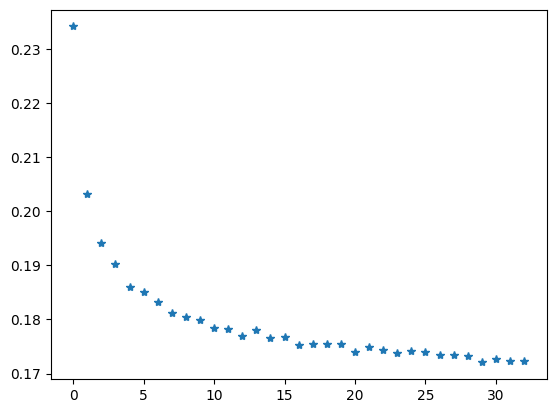

In [11]:
plt.plot(losses, '*')

In [12]:
mlr_threshold = None
ts_batch_size = int(1e3)
onlinac, best_probability, meanac, lastac = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, sensor_size, testset_output.ordering, n_classes, ts_size = ts_size, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, save_likelihood = False)

Number of chance decisions: 0
90th quantile for number of events: 114932.70000000004
Mean accuracy: 45.0%
Last accuracy: 61.7%
Highest probability accuracy: 73.5%


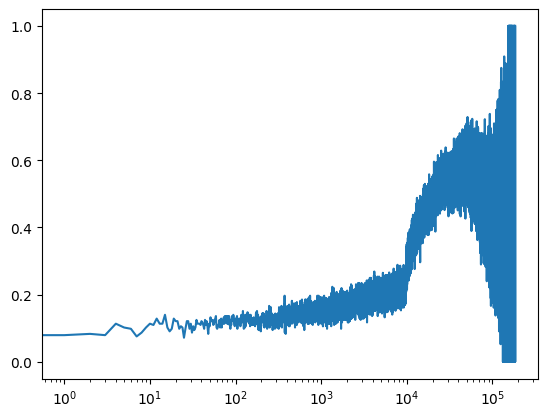

In [13]:
plt.semilogx(onlinac)

In [14]:
mlr_threshold = .9
ts_batch_size = int(1e3)
onlinac, best_probability, meanac, lastac = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, sensor_size, testset_output.ordering, n_classes, ts_size = ts_size, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, save_likelihood = False)

Number of chance decisions: 16
90th quantile for number of events: 114932.70000000004
Mean accuracy: 49.6%
Last accuracy: 22.0%
Highest probability accuracy: 73.5%
